In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
%%bash


URL=/content/drive/My Drive/Data/bundle_archive.zip
mkdir ./datasets/
ZIP_FILE=./datasets/bundle_archive.zip
TARGET_DIR=./datasets/datasets/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Data/bundle_archive.zip', 'r')
zip_ref.extractall('./content/drive/My Drive/Data/')
zip_ref.close()

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"


In [119]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

normal_images  = []
potholes_images = []
path_normal = '/content/content/drive/My Drive/Data/normal'
path_potholes = '/content/content/drive/My Drive/Data/potholes/'

for dirname, _, filenames in os.walk(path_normal):
    for filename in tqdm(filenames):
        try:
            img = cv2.imread(os.path.join(path_normal,filename) , cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img , (50,50))
            normal_images.append(np.array(img))
        except Exception as e:
            pass
        
for dirname, _, filenames in os.walk(path_potholes):
    for filename in tqdm(filenames):
        try:
            img = cv2.imread(os.path.join(path_potholes,filename) , cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img , (50,50))
            potholes_images.append(np.array(img))
        except Exception as e:
            pass
print(len(normal_images))
print(len(potholes_images))

processed_data = []
for img in normal_images:
    t = torch.LongTensor(1)
    t[0] = 0
    img = torch.FloatTensor(img)
    processed_data.append([img/255,t])
for img in potholes_images:
    t = torch.LongTensor(1)
    t[0] = 1
    img = torch.FloatTensor(img)
    processed_data.append([img/255,t])
                           
print(len(processed_data))
shuffle(processed_data)

train_data = processed_data[70:]
test_data = processed_data[0:70]

print(f"size of training data {len(train_data)}")
print(f"size of testing data {len(test_data)}")


100%|██████████| 352/352 [00:06<00:00, 53.16it/s]

100%|██████████| 329/329 [00:08<00:00, 39.99it/s]


351
329
680
size of training data 610
size of testing data 70


In [6]:
normal_addr = [path_normal+"/"+i for i in os.listdir(path_normal)]
potholes_addr = [path_potholes+"/"+i for i in os.listdir(path_potholes)]

In [7]:
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

def show_image(photo_addr):
    img = Image.open(photo_addr).convert('RGB')
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    plt.figure()
    plt.show()

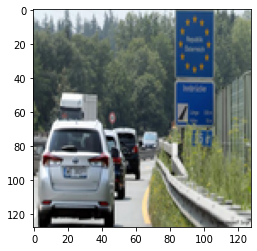

<Figure size 432x288 with 0 Axes>

In [8]:
show_image(normal_addr[randint(0,(len(normal_addr)))])

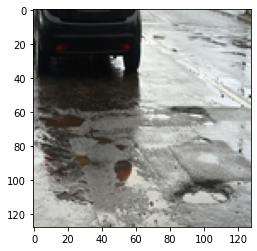

<Figure size 432x288 with 0 Axes>

In [9]:
show_image(potholes_addr[randint(0,(len(potholes_addr)))])


In [126]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv4 = nn.Conv2d(128,256,3)

        
        x = torch.rand(1,50,50).view(-1,1,50,50)
        self.linear_in = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self.linear_in,1024)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024,2048)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(2048,2)

        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)) , (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)) , (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)) , (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)) , (2,2))

        
        if self.linear_in == None:
            self.linear_in = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] 
        else:
            return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self.linear_in)
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = self.fc2(x)
        x = self.droput(x)
        x = self.fc3(x)
        return F.log_softmax(x , dim = 1)

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (droput): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2, bias=True)
)

In [127]:
import torch.optim as optim

def train_model(Net , train_data):
    optimizer  = optim.Adam(net.parameters(),lr = 0.00001)
    loss_function = nn.CrossEntropyLoss()
    losses=[]
    for epoch in tqdm(range(500)):
        for i in (range(0,610,10)):
            batch = train_data[i:i+10]
            batch_x = torch.cuda.FloatTensor(10,1,50,50)
            batch_y = torch.cuda.LongTensor(10,1)

            for i in range(10):
                batch_x[i] = batch[i][0]
                batch_y[i] = batch[i][1]
            batch_x.to(device)
            batch_y.to(device)
            net.zero_grad()
            outputs = net(batch_x.view(-1,1,50,50))
            batch_y = batch_y.view(10)
            loss = F.nll_loss(outputs , batch_y)
            loss.backward()
            optimizer.step()
        losses.append(loss)
        print(f"epoch : {epoch}  loss : {loss}")
    return losses

In [128]:
def test_model(Net,test_data):
    correct = 0
    total = 0
    scores=[]
    with torch.no_grad():
        for data in tqdm(test_data):
            x = torch.FloatTensor(data[0])
            y = torch.LongTensor(data[1])

            x = x.view(-1,1,50,50)
            x = x.to(device)
            output = net(x)
            output = output.view(2)
            if(max(output[0],output[1]) == output[0]):
                index = 0
            else:
                index = 1
            if index == y[0]:
                correct += 1
                if total>2:
                  scores.append(round(correct/total , 5))

            total += 1
        return round(correct/total , 5), scores

In [129]:
losses = train_model(net,train_data)
acc,scores = test_model(net,test_data)
print(acc)


  0%|          | 1/500 [00:00<03:20,  2.49it/s]

epoch : 0  loss : 0.6861256957054138



  0%|          | 2/500 [00:00<03:19,  2.50it/s]

epoch : 1  loss : 0.6959983706474304



  1%|          | 3/500 [00:01<03:17,  2.52it/s]

epoch : 2  loss : 0.6881206631660461



  1%|          | 4/500 [00:01<03:16,  2.52it/s]

epoch : 3  loss : 0.6906505823135376



  1%|          | 5/500 [00:01<03:17,  2.51it/s]

epoch : 4  loss : 0.6926696300506592



  1%|          | 6/500 [00:02<03:16,  2.51it/s]

epoch : 5  loss : 0.699096143245697



  1%|▏         | 7/500 [00:02<03:15,  2.52it/s]

epoch : 6  loss : 0.6859633326530457



  2%|▏         | 8/500 [00:03<03:14,  2.53it/s]

epoch : 7  loss : 0.6930003762245178



  2%|▏         | 9/500 [00:03<03:13,  2.54it/s]

epoch : 8  loss : 0.6920188069343567



  2%|▏         | 10/500 [00:03<03:12,  2.54it/s]

epoch : 9  loss : 0.6926762461662292



  2%|▏         | 11/500 [00:04<03:13,  2.53it/s]

epoch : 10  loss : 0.6898581981658936



  2%|▏         | 12/500 [00:04<03:12,  2.53it/s]

epoch : 11  loss : 0.6823557019233704



  3%|▎         | 13/500 [00:05<03:13,  2.51it/s]

epoch : 12  loss : 0.6922014951705933



  3%|▎         | 14/500 [00:05<03:13,  2.51it/s]

epoch : 13  loss : 0.6825693249702454



  3%|▎         | 15/500 [00:05<03:12,  2.52it/s]

epoch : 14  loss : 0.7103758454322815



  3%|▎         | 16/500 [00:06<03:10,  2.54it/s]

epoch : 15  loss : 0.7000418901443481



  3%|▎         | 17/500 [00:06<03:13,  2.49it/s]

epoch : 16  loss : 0.6720284819602966



  4%|▎         | 18/500 [00:07<03:11,  2.52it/s]

epoch : 17  loss : 0.7014186382293701



  4%|▍         | 19/500 [00:07<03:12,  2.50it/s]

epoch : 18  loss : 0.6584538221359253



  4%|▍         | 20/500 [00:07<03:11,  2.51it/s]

epoch : 19  loss : 0.6498916149139404



  4%|▍         | 21/500 [00:08<03:11,  2.51it/s]

epoch : 20  loss : 0.6597708463668823



  4%|▍         | 22/500 [00:08<03:10,  2.51it/s]

epoch : 21  loss : 0.6322070360183716



  5%|▍         | 23/500 [00:09<03:11,  2.49it/s]

epoch : 22  loss : 0.6431635618209839



  5%|▍         | 24/500 [00:09<03:09,  2.51it/s]

epoch : 23  loss : 0.6388788223266602



  5%|▌         | 25/500 [00:09<03:06,  2.54it/s]

epoch : 24  loss : 0.607212245464325



  5%|▌         | 26/500 [00:10<03:05,  2.55it/s]

epoch : 25  loss : 0.5557501316070557



  5%|▌         | 27/500 [00:10<03:06,  2.54it/s]

epoch : 26  loss : 0.5697342753410339



  6%|▌         | 28/500 [00:11<03:05,  2.55it/s]

epoch : 27  loss : 0.5413156747817993



  6%|▌         | 29/500 [00:11<03:04,  2.55it/s]

epoch : 28  loss : 0.586866557598114



  6%|▌         | 30/500 [00:11<03:05,  2.53it/s]

epoch : 29  loss : 0.5598853826522827



  6%|▌         | 31/500 [00:12<03:06,  2.51it/s]

epoch : 30  loss : 0.5816949605941772



  6%|▋         | 32/500 [00:12<03:06,  2.51it/s]

epoch : 31  loss : 0.5349777936935425



  7%|▋         | 33/500 [00:13<03:06,  2.50it/s]

epoch : 32  loss : 0.5108319520950317



  7%|▋         | 34/500 [00:13<03:05,  2.51it/s]

epoch : 33  loss : 0.5868188142776489



  7%|▋         | 35/500 [00:13<03:04,  2.52it/s]

epoch : 34  loss : 0.5251425504684448



  7%|▋         | 36/500 [00:14<03:02,  2.54it/s]

epoch : 35  loss : 0.5652765035629272



  7%|▋         | 37/500 [00:14<03:03,  2.53it/s]

epoch : 36  loss : 0.5857608914375305



  8%|▊         | 38/500 [00:15<03:04,  2.50it/s]

epoch : 37  loss : 0.5266280174255371



  8%|▊         | 39/500 [00:15<03:03,  2.51it/s]

epoch : 38  loss : 0.544299304485321



  8%|▊         | 40/500 [00:15<03:02,  2.52it/s]

epoch : 39  loss : 0.5290468335151672



  8%|▊         | 41/500 [00:16<03:01,  2.53it/s]

epoch : 40  loss : 0.5815065503120422



  8%|▊         | 42/500 [00:16<03:01,  2.52it/s]

epoch : 41  loss : 0.5541388392448425



  9%|▊         | 43/500 [00:17<02:58,  2.55it/s]

epoch : 42  loss : 0.52720046043396



  9%|▉         | 44/500 [00:17<02:57,  2.57it/s]

epoch : 43  loss : 0.5776804089546204



  9%|▉         | 45/500 [00:17<02:57,  2.56it/s]

epoch : 44  loss : 0.49063047766685486



  9%|▉         | 46/500 [00:18<02:56,  2.57it/s]

epoch : 45  loss : 0.5589557886123657



  9%|▉         | 47/500 [00:18<02:57,  2.56it/s]

epoch : 46  loss : 0.5536693930625916



 10%|▉         | 48/500 [00:18<02:55,  2.58it/s]

epoch : 47  loss : 0.5792679786682129



 10%|▉         | 49/500 [00:19<02:55,  2.57it/s]

epoch : 48  loss : 0.48258599638938904



 10%|█         | 50/500 [00:19<02:55,  2.57it/s]

epoch : 49  loss : 0.5284834504127502



 10%|█         | 51/500 [00:20<02:54,  2.57it/s]

epoch : 50  loss : 0.5342642068862915



 10%|█         | 52/500 [00:20<02:56,  2.54it/s]

epoch : 51  loss : 0.5120319724082947



 11%|█         | 53/500 [00:20<02:55,  2.54it/s]

epoch : 52  loss : 0.5050252079963684



 11%|█         | 54/500 [00:21<02:55,  2.54it/s]

epoch : 53  loss : 0.5116468667984009



 11%|█         | 55/500 [00:21<02:55,  2.53it/s]

epoch : 54  loss : 0.5542210340499878



 11%|█         | 56/500 [00:22<02:55,  2.53it/s]

epoch : 55  loss : 0.5182138681411743



 11%|█▏        | 57/500 [00:22<02:55,  2.53it/s]

epoch : 56  loss : 0.5410277843475342



 12%|█▏        | 58/500 [00:22<02:52,  2.56it/s]

epoch : 57  loss : 0.5266701579093933



 12%|█▏        | 59/500 [00:23<02:55,  2.51it/s]

epoch : 58  loss : 0.5382175445556641



 12%|█▏        | 60/500 [00:23<02:54,  2.53it/s]

epoch : 59  loss : 0.5678132176399231



 12%|█▏        | 61/500 [00:24<02:53,  2.53it/s]

epoch : 60  loss : 0.5226691961288452



 12%|█▏        | 62/500 [00:24<02:52,  2.53it/s]

epoch : 61  loss : 0.5514856576919556



 13%|█▎        | 63/500 [00:24<02:51,  2.55it/s]

epoch : 62  loss : 0.5450865626335144



 13%|█▎        | 64/500 [00:25<02:50,  2.56it/s]

epoch : 63  loss : 0.504726767539978



 13%|█▎        | 65/500 [00:25<02:50,  2.55it/s]

epoch : 64  loss : 0.5260288119316101



 13%|█▎        | 66/500 [00:26<02:49,  2.56it/s]

epoch : 65  loss : 0.5514654517173767



 13%|█▎        | 67/500 [00:26<02:48,  2.57it/s]

epoch : 66  loss : 0.5875923037528992



 14%|█▎        | 68/500 [00:26<02:47,  2.58it/s]

epoch : 67  loss : 0.4950169622898102



 14%|█▍        | 69/500 [00:27<02:49,  2.54it/s]

epoch : 68  loss : 0.4603135585784912



 14%|█▍        | 70/500 [00:27<02:48,  2.55it/s]

epoch : 69  loss : 0.5107492208480835



 14%|█▍        | 71/500 [00:28<02:47,  2.56it/s]

epoch : 70  loss : 0.5340951085090637



 14%|█▍        | 72/500 [00:28<02:49,  2.53it/s]

epoch : 71  loss : 0.5193353295326233



 15%|█▍        | 73/500 [00:28<02:47,  2.54it/s]

epoch : 72  loss : 0.5904754400253296



 15%|█▍        | 74/500 [00:29<02:47,  2.54it/s]

epoch : 73  loss : 0.46031880378723145



 15%|█▌        | 75/500 [00:29<02:47,  2.54it/s]

epoch : 74  loss : 0.5603209733963013



 15%|█▌        | 76/500 [00:29<02:47,  2.54it/s]

epoch : 75  loss : 0.42675337195396423



 15%|█▌        | 77/500 [00:30<02:46,  2.55it/s]

epoch : 76  loss : 0.3967103660106659



 16%|█▌        | 78/500 [00:30<02:45,  2.55it/s]

epoch : 77  loss : 0.47075319290161133



 16%|█▌        | 79/500 [00:31<02:45,  2.55it/s]

epoch : 78  loss : 0.4884718358516693



 16%|█▌        | 80/500 [00:31<02:45,  2.54it/s]

epoch : 79  loss : 0.4630962014198303



 16%|█▌        | 81/500 [00:31<02:44,  2.54it/s]

epoch : 80  loss : 0.46349582076072693



 16%|█▋        | 82/500 [00:32<02:44,  2.54it/s]

epoch : 81  loss : 0.42524033784866333



 17%|█▋        | 83/500 [00:32<02:45,  2.52it/s]

epoch : 82  loss : 0.4422232508659363



 17%|█▋        | 84/500 [00:33<02:45,  2.52it/s]

epoch : 83  loss : 0.4453431963920593



 17%|█▋        | 85/500 [00:33<02:45,  2.51it/s]

epoch : 84  loss : 0.5254650115966797



 17%|█▋        | 86/500 [00:33<02:44,  2.52it/s]

epoch : 85  loss : 0.4060608744621277



 17%|█▋        | 87/500 [00:34<02:42,  2.54it/s]

epoch : 86  loss : 0.44886380434036255



 18%|█▊        | 88/500 [00:34<02:44,  2.51it/s]

epoch : 87  loss : 0.5475481152534485



 18%|█▊        | 89/500 [00:35<02:43,  2.52it/s]

epoch : 88  loss : 0.4453009068965912



 18%|█▊        | 90/500 [00:35<02:42,  2.53it/s]

epoch : 89  loss : 0.5354140996932983



 18%|█▊        | 91/500 [00:35<02:42,  2.52it/s]

epoch : 90  loss : 0.48591119050979614



 18%|█▊        | 92/500 [00:36<02:41,  2.53it/s]

epoch : 91  loss : 0.4843694567680359



 19%|█▊        | 93/500 [00:36<02:42,  2.51it/s]

epoch : 92  loss : 0.39979317784309387



 19%|█▉        | 94/500 [00:37<02:41,  2.52it/s]

epoch : 93  loss : 0.40849247574806213



 19%|█▉        | 95/500 [00:37<02:40,  2.52it/s]

epoch : 94  loss : 0.4153992235660553



 19%|█▉        | 96/500 [00:37<02:40,  2.52it/s]

epoch : 95  loss : 0.4718324542045593



 19%|█▉        | 97/500 [00:38<02:38,  2.55it/s]

epoch : 96  loss : 0.3739508092403412



 20%|█▉        | 98/500 [00:38<02:40,  2.50it/s]

epoch : 97  loss : 0.41703519225120544



 20%|█▉        | 99/500 [00:39<02:42,  2.47it/s]

epoch : 98  loss : 0.4790242612361908



 20%|██        | 100/500 [00:39<02:43,  2.45it/s]

epoch : 99  loss : 0.34296923875808716



 20%|██        | 101/500 [00:39<02:42,  2.46it/s]

epoch : 100  loss : 0.30275410413742065



 20%|██        | 102/500 [00:40<02:40,  2.47it/s]

epoch : 101  loss : 0.3683185577392578



 21%|██        | 103/500 [00:40<02:39,  2.48it/s]

epoch : 102  loss : 0.40061911940574646



 21%|██        | 104/500 [00:41<02:40,  2.47it/s]

epoch : 103  loss : 0.43035537004470825



 21%|██        | 105/500 [00:41<02:40,  2.46it/s]

epoch : 104  loss : 0.322833776473999



 21%|██        | 106/500 [00:41<02:38,  2.48it/s]

epoch : 105  loss : 0.3580060303211212



 21%|██▏       | 107/500 [00:42<02:37,  2.50it/s]

epoch : 106  loss : 0.3861893117427826



 22%|██▏       | 108/500 [00:42<02:37,  2.48it/s]

epoch : 107  loss : 0.41358470916748047



 22%|██▏       | 109/500 [00:43<02:37,  2.48it/s]

epoch : 108  loss : 0.34134697914123535



 22%|██▏       | 110/500 [00:43<02:35,  2.51it/s]

epoch : 109  loss : 0.35555198788642883



 22%|██▏       | 111/500 [00:43<02:35,  2.50it/s]

epoch : 110  loss : 0.34374573826789856



 22%|██▏       | 112/500 [00:44<02:33,  2.53it/s]

epoch : 111  loss : 0.3648870587348938



 23%|██▎       | 113/500 [00:44<02:33,  2.52it/s]

epoch : 112  loss : 0.33282265067100525



 23%|██▎       | 114/500 [00:45<02:32,  2.54it/s]

epoch : 113  loss : 0.2747027277946472



 23%|██▎       | 115/500 [00:45<02:30,  2.55it/s]

epoch : 114  loss : 0.2754235565662384



 23%|██▎       | 116/500 [00:45<02:30,  2.55it/s]

epoch : 115  loss : 0.26820605993270874



 23%|██▎       | 117/500 [00:46<02:31,  2.54it/s]

epoch : 116  loss : 0.2745570242404938



 24%|██▎       | 118/500 [00:46<02:29,  2.55it/s]

epoch : 117  loss : 0.2874144911766052



 24%|██▍       | 119/500 [00:47<02:29,  2.55it/s]

epoch : 118  loss : 0.3025277256965637



 24%|██▍       | 120/500 [00:47<02:29,  2.53it/s]

epoch : 119  loss : 0.3204588294029236



 24%|██▍       | 121/500 [00:47<02:28,  2.55it/s]

epoch : 120  loss : 0.2579371929168701



 24%|██▍       | 122/500 [00:48<02:28,  2.55it/s]

epoch : 121  loss : 0.2917281985282898



 25%|██▍       | 123/500 [00:48<02:27,  2.55it/s]

epoch : 122  loss : 0.21466419100761414



 25%|██▍       | 124/500 [00:49<02:28,  2.53it/s]

epoch : 123  loss : 0.23223371803760529



 25%|██▌       | 125/500 [00:49<02:27,  2.54it/s]

epoch : 124  loss : 0.26047855615615845



 25%|██▌       | 126/500 [00:49<02:27,  2.53it/s]

epoch : 125  loss : 0.23639976978302002



 25%|██▌       | 127/500 [00:50<02:27,  2.53it/s]

epoch : 126  loss : 0.3340371549129486



 26%|██▌       | 128/500 [00:50<02:27,  2.53it/s]

epoch : 127  loss : 0.15745870769023895



 26%|██▌       | 129/500 [00:51<02:26,  2.53it/s]

epoch : 128  loss : 0.15905092656612396



 26%|██▌       | 130/500 [00:51<02:26,  2.53it/s]

epoch : 129  loss : 0.3324645757675171



 26%|██▌       | 131/500 [00:51<02:26,  2.52it/s]

epoch : 130  loss : 0.18779650330543518



 26%|██▋       | 132/500 [00:52<02:26,  2.52it/s]

epoch : 131  loss : 0.20912833511829376



 27%|██▋       | 133/500 [00:52<02:24,  2.54it/s]

epoch : 132  loss : 0.23822203278541565



 27%|██▋       | 134/500 [00:53<02:24,  2.54it/s]

epoch : 133  loss : 0.20749883353710175



 27%|██▋       | 135/500 [00:53<02:23,  2.54it/s]

epoch : 134  loss : 0.1823788583278656



 27%|██▋       | 136/500 [00:53<02:22,  2.55it/s]

epoch : 135  loss : 0.16781359910964966



 27%|██▋       | 137/500 [00:54<02:22,  2.55it/s]

epoch : 136  loss : 0.18979443609714508



 28%|██▊       | 138/500 [00:54<02:22,  2.54it/s]

epoch : 137  loss : 0.12048590183258057



 28%|██▊       | 139/500 [00:54<02:22,  2.53it/s]

epoch : 138  loss : 0.15787971019744873



 28%|██▊       | 140/500 [00:55<02:21,  2.55it/s]

epoch : 139  loss : 0.09632700681686401



 28%|██▊       | 141/500 [00:55<02:19,  2.57it/s]

epoch : 140  loss : 0.14779573678970337



 28%|██▊       | 142/500 [00:56<02:20,  2.55it/s]

epoch : 141  loss : 0.10262942314147949



 29%|██▊       | 143/500 [00:56<02:20,  2.55it/s]

epoch : 142  loss : 0.12030772119760513



 29%|██▉       | 144/500 [00:56<02:20,  2.53it/s]

epoch : 143  loss : 0.08910372108221054



 29%|██▉       | 145/500 [00:57<02:19,  2.54it/s]

epoch : 144  loss : 0.06842590123414993



 29%|██▉       | 146/500 [00:57<02:18,  2.55it/s]

epoch : 145  loss : 0.12456240504980087



 29%|██▉       | 147/500 [00:58<02:19,  2.54it/s]

epoch : 146  loss : 0.115744948387146



 30%|██▉       | 148/500 [00:58<02:17,  2.56it/s]

epoch : 147  loss : 0.09371323883533478



 30%|██▉       | 149/500 [00:58<02:15,  2.58it/s]

epoch : 148  loss : 0.07757757604122162



 30%|███       | 150/500 [00:59<02:15,  2.58it/s]

epoch : 149  loss : 0.09649714082479477



 30%|███       | 151/500 [00:59<02:15,  2.58it/s]

epoch : 150  loss : 0.07698263227939606



 30%|███       | 152/500 [01:00<02:15,  2.58it/s]

epoch : 151  loss : 0.05594993755221367



 31%|███       | 153/500 [01:00<02:14,  2.57it/s]

epoch : 152  loss : 0.06859691441059113



 31%|███       | 154/500 [01:00<02:14,  2.57it/s]

epoch : 153  loss : 0.07514718174934387



 31%|███       | 155/500 [01:01<02:15,  2.55it/s]

epoch : 154  loss : 0.08567579090595245



 31%|███       | 156/500 [01:01<02:15,  2.54it/s]

epoch : 155  loss : 0.04986577481031418



 31%|███▏      | 157/500 [01:02<02:15,  2.53it/s]

epoch : 156  loss : 0.09829641878604889



 32%|███▏      | 158/500 [01:02<02:16,  2.50it/s]

epoch : 157  loss : 0.10899032652378082



 32%|███▏      | 159/500 [01:02<02:15,  2.52it/s]

epoch : 158  loss : 0.04915923625230789



 32%|███▏      | 160/500 [01:03<02:16,  2.50it/s]

epoch : 159  loss : 0.09435154497623444



 32%|███▏      | 161/500 [01:03<02:15,  2.51it/s]

epoch : 160  loss : 0.03688916563987732



 32%|███▏      | 162/500 [01:04<02:15,  2.49it/s]

epoch : 161  loss : 0.0609382763504982



 33%|███▎      | 163/500 [01:04<02:16,  2.48it/s]

epoch : 162  loss : 0.04904240742325783



 33%|███▎      | 164/500 [01:04<02:15,  2.49it/s]

epoch : 163  loss : 0.055234361439943314



 33%|███▎      | 165/500 [01:05<02:13,  2.50it/s]

epoch : 164  loss : 0.03948844596743584



 33%|███▎      | 166/500 [01:05<02:12,  2.52it/s]

epoch : 165  loss : 0.03365422412753105



 33%|███▎      | 167/500 [01:06<02:11,  2.53it/s]

epoch : 166  loss : 0.03664937615394592



 34%|███▎      | 168/500 [01:06<02:12,  2.51it/s]

epoch : 167  loss : 0.05561090633273125



 34%|███▍      | 169/500 [01:06<02:12,  2.51it/s]

epoch : 168  loss : 0.08358932286500931



 34%|███▍      | 170/500 [01:07<02:10,  2.52it/s]

epoch : 169  loss : 0.08776276558637619



 34%|███▍      | 171/500 [01:07<02:10,  2.52it/s]

epoch : 170  loss : 0.04050664231181145



 34%|███▍      | 172/500 [01:07<02:09,  2.54it/s]

epoch : 171  loss : 0.04414863511919975



 35%|███▍      | 173/500 [01:08<02:10,  2.50it/s]

epoch : 172  loss : 0.05184461921453476



 35%|███▍      | 174/500 [01:08<02:08,  2.54it/s]

epoch : 173  loss : 0.04982714727520943



 35%|███▌      | 175/500 [01:09<02:09,  2.51it/s]

epoch : 174  loss : 0.05641796439886093



 35%|███▌      | 176/500 [01:09<02:08,  2.53it/s]

epoch : 175  loss : 0.06072821095585823



 35%|███▌      | 177/500 [01:09<02:06,  2.56it/s]

epoch : 176  loss : 0.05540413782000542



 36%|███▌      | 178/500 [01:10<02:06,  2.55it/s]

epoch : 177  loss : 0.0319385752081871



 36%|███▌      | 179/500 [01:10<02:04,  2.57it/s]

epoch : 178  loss : 0.1052013486623764



 36%|███▌      | 180/500 [01:11<02:03,  2.60it/s]

epoch : 179  loss : 0.09317056089639664



 36%|███▌      | 181/500 [01:11<02:03,  2.59it/s]

epoch : 180  loss : 0.08364057540893555



 36%|███▋      | 182/500 [01:11<02:04,  2.56it/s]

epoch : 181  loss : 0.14698004722595215



 37%|███▋      | 183/500 [01:12<02:04,  2.55it/s]

epoch : 182  loss : 0.11566932499408722



 37%|███▋      | 184/500 [01:12<02:03,  2.55it/s]

epoch : 183  loss : 0.06198262423276901



 37%|███▋      | 185/500 [01:13<02:03,  2.56it/s]

epoch : 184  loss : 0.08255457133054733



 37%|███▋      | 186/500 [01:13<02:03,  2.55it/s]

epoch : 185  loss : 0.09557773172855377



 37%|███▋      | 187/500 [01:13<02:03,  2.53it/s]

epoch : 186  loss : 0.013370394706726074



 38%|███▊      | 188/500 [01:14<02:02,  2.54it/s]

epoch : 187  loss : 0.1007925420999527



 38%|███▊      | 189/500 [01:14<02:01,  2.55it/s]

epoch : 188  loss : 0.04368218779563904



 38%|███▊      | 190/500 [01:15<02:01,  2.54it/s]

epoch : 189  loss : 0.04174213856458664



 38%|███▊      | 191/500 [01:15<02:02,  2.52it/s]

epoch : 190  loss : 0.011229502968490124



 38%|███▊      | 192/500 [01:15<02:02,  2.52it/s]

epoch : 191  loss : 0.005600356962531805



 39%|███▊      | 193/500 [01:16<02:01,  2.53it/s]

epoch : 192  loss : 0.016349267214536667



 39%|███▉      | 194/500 [01:16<02:01,  2.51it/s]

epoch : 193  loss : 0.013636541552841663



 39%|███▉      | 195/500 [01:17<02:00,  2.53it/s]

epoch : 194  loss : 0.008589208126068115



 39%|███▉      | 196/500 [01:17<02:00,  2.51it/s]

epoch : 195  loss : 0.01534816063940525



 39%|███▉      | 197/500 [01:17<01:59,  2.53it/s]

epoch : 196  loss : 0.0041619776748120785



 40%|███▉      | 198/500 [01:18<01:59,  2.53it/s]

epoch : 197  loss : 0.00915514212101698



 40%|███▉      | 199/500 [01:18<01:58,  2.55it/s]

epoch : 198  loss : 0.012325584888458252



 40%|████      | 200/500 [01:19<01:58,  2.53it/s]

epoch : 199  loss : 0.006101787090301514



 40%|████      | 201/500 [01:19<01:58,  2.53it/s]

epoch : 200  loss : 0.03684970736503601



 40%|████      | 202/500 [01:19<01:57,  2.55it/s]

epoch : 201  loss : 0.010727191343903542



 41%|████      | 203/500 [01:20<01:55,  2.57it/s]

epoch : 202  loss : 0.0035535574425011873



 41%|████      | 204/500 [01:20<01:55,  2.57it/s]

epoch : 203  loss : 0.003520107362419367



 41%|████      | 205/500 [01:20<01:54,  2.57it/s]

epoch : 204  loss : 0.0068579078651964664



 41%|████      | 206/500 [01:21<01:55,  2.55it/s]

epoch : 205  loss : 0.004020405001938343



 41%|████▏     | 207/500 [01:21<01:55,  2.54it/s]

epoch : 206  loss : 0.008572494611144066



 42%|████▏     | 208/500 [01:22<01:55,  2.53it/s]

epoch : 207  loss : 0.006498396396636963



 42%|████▏     | 209/500 [01:22<01:55,  2.53it/s]

epoch : 208  loss : 0.007401907350867987



 42%|████▏     | 210/500 [01:22<01:54,  2.53it/s]

epoch : 209  loss : 0.0032226801849901676



 42%|████▏     | 211/500 [01:23<01:54,  2.52it/s]

epoch : 210  loss : 0.0055477977730333805



 42%|████▏     | 212/500 [01:23<01:54,  2.52it/s]

epoch : 211  loss : 0.007631456945091486



 43%|████▎     | 213/500 [01:24<01:53,  2.52it/s]

epoch : 212  loss : 0.005519175436347723



 43%|████▎     | 214/500 [01:24<01:54,  2.51it/s]

epoch : 213  loss : 0.0029779435135424137



 43%|████▎     | 215/500 [01:24<01:53,  2.51it/s]

epoch : 214  loss : 0.005486810114234686



 43%|████▎     | 216/500 [01:25<01:53,  2.51it/s]

epoch : 215  loss : 0.008066058158874512



 43%|████▎     | 217/500 [01:25<01:52,  2.51it/s]

epoch : 216  loss : 0.00390017032623291



 44%|████▎     | 218/500 [01:26<01:51,  2.53it/s]

epoch : 217  loss : 0.003551530884578824



 44%|████▍     | 219/500 [01:26<01:51,  2.53it/s]

epoch : 218  loss : 0.004512465093284845



 44%|████▍     | 220/500 [01:26<01:51,  2.52it/s]

epoch : 219  loss : 0.0030157328583300114



 44%|████▍     | 221/500 [01:27<01:49,  2.54it/s]

epoch : 220  loss : 0.003283882047981024



 44%|████▍     | 222/500 [01:27<01:50,  2.52it/s]

epoch : 221  loss : 0.0038924694526940584



 45%|████▍     | 223/500 [01:28<01:49,  2.52it/s]

epoch : 222  loss : 0.00346872815862298



 45%|████▍     | 224/500 [01:28<01:50,  2.51it/s]

epoch : 223  loss : 0.007636642549186945



 45%|████▌     | 225/500 [01:28<01:49,  2.51it/s]

epoch : 224  loss : 0.003459680126979947



 45%|████▌     | 226/500 [01:29<01:47,  2.55it/s]

epoch : 225  loss : 0.014271807856857777



 45%|████▌     | 227/500 [01:29<01:47,  2.53it/s]

epoch : 226  loss : 0.0032986521255224943



 46%|████▌     | 228/500 [01:30<01:47,  2.53it/s]

epoch : 227  loss : 0.008268177509307861



 46%|████▌     | 229/500 [01:30<01:46,  2.54it/s]

epoch : 228  loss : 0.009172153659164906



 46%|████▌     | 230/500 [01:30<01:47,  2.52it/s]

epoch : 229  loss : 0.0008329153060913086



 46%|████▌     | 231/500 [01:31<01:46,  2.52it/s]

epoch : 230  loss : 0.0025120496284216642



 46%|████▋     | 232/500 [01:31<01:47,  2.50it/s]

epoch : 231  loss : 0.005966878030449152



 47%|████▋     | 233/500 [01:32<01:46,  2.51it/s]

epoch : 232  loss : 0.0029528618324548006



 47%|████▋     | 234/500 [01:32<01:45,  2.52it/s]

epoch : 233  loss : 0.0022614479530602694



 47%|████▋     | 235/500 [01:32<01:45,  2.52it/s]

epoch : 234  loss : 0.0016832590335980058



 47%|████▋     | 236/500 [01:33<01:43,  2.55it/s]

epoch : 235  loss : 0.002122425939887762



 47%|████▋     | 237/500 [01:33<01:43,  2.53it/s]

epoch : 236  loss : 0.00181493756826967



 48%|████▊     | 238/500 [01:34<01:43,  2.52it/s]

epoch : 237  loss : 0.0012473106617107987



 48%|████▊     | 239/500 [01:34<01:42,  2.54it/s]

epoch : 238  loss : 0.005771815776824951



 48%|████▊     | 240/500 [01:34<01:42,  2.54it/s]

epoch : 239  loss : 0.0014278411399573088



 48%|████▊     | 241/500 [01:35<01:41,  2.56it/s]

epoch : 240  loss : 0.0013819218147546053



 48%|████▊     | 242/500 [01:35<01:41,  2.54it/s]

epoch : 241  loss : 0.002640199614688754



 49%|████▊     | 243/500 [01:36<01:41,  2.52it/s]

epoch : 242  loss : 0.002000951673835516



 49%|████▉     | 244/500 [01:36<01:41,  2.52it/s]

epoch : 243  loss : 0.002121472265571356



 49%|████▉     | 245/500 [01:36<01:41,  2.51it/s]

epoch : 244  loss : 0.0025444745551794767



 49%|████▉     | 246/500 [01:37<01:40,  2.54it/s]

epoch : 245  loss : 0.0008284092182293534



 49%|████▉     | 247/500 [01:37<01:39,  2.55it/s]

epoch : 246  loss : 0.008169794455170631



 50%|████▉     | 248/500 [01:37<01:39,  2.54it/s]

epoch : 247  loss : 0.004493021871894598



 50%|████▉     | 249/500 [01:38<01:37,  2.57it/s]

epoch : 248  loss : 0.017390776425600052



 50%|█████     | 250/500 [01:38<01:36,  2.59it/s]

epoch : 249  loss : 0.010037469677627087



 50%|█████     | 251/500 [01:39<01:36,  2.57it/s]

epoch : 250  loss : 0.01066899299621582



 50%|█████     | 252/500 [01:39<01:36,  2.58it/s]

epoch : 251  loss : 0.0041847825050354



 51%|█████     | 253/500 [01:39<01:36,  2.56it/s]

epoch : 252  loss : 0.0006065130000934005



 51%|█████     | 254/500 [01:40<01:35,  2.58it/s]

epoch : 253  loss : 0.008646940812468529



 51%|█████     | 255/500 [01:40<01:36,  2.54it/s]

epoch : 254  loss : 0.009228765964508057



 51%|█████     | 256/500 [01:41<01:36,  2.54it/s]

epoch : 255  loss : 0.029984528198838234



 51%|█████▏    | 257/500 [01:41<01:35,  2.53it/s]

epoch : 256  loss : 0.004007565788924694



 52%|█████▏    | 258/500 [01:41<01:34,  2.55it/s]

epoch : 257  loss : 0.0001365184725727886



 52%|█████▏    | 259/500 [01:42<01:34,  2.56it/s]

epoch : 258  loss : 0.0033969164360314608



 52%|█████▏    | 260/500 [01:42<01:33,  2.56it/s]

epoch : 259  loss : 0.002553927944973111



 52%|█████▏    | 261/500 [01:43<01:33,  2.55it/s]

epoch : 260  loss : 0.003278374671936035



 52%|█████▏    | 262/500 [01:43<01:33,  2.54it/s]

epoch : 261  loss : 0.013391983695328236



 53%|█████▎    | 263/500 [01:43<01:33,  2.53it/s]

epoch : 262  loss : 0.00024900436983443797



 53%|█████▎    | 264/500 [01:44<01:32,  2.54it/s]

epoch : 263  loss : 0.04280373454093933



 53%|█████▎    | 265/500 [01:44<01:31,  2.57it/s]

epoch : 264  loss : 0.020639514550566673



 53%|█████▎    | 266/500 [01:45<01:31,  2.56it/s]

epoch : 265  loss : 0.019273817539215088



 53%|█████▎    | 267/500 [01:45<01:31,  2.55it/s]

epoch : 266  loss : 0.0008329153060913086



 54%|█████▎    | 268/500 [01:45<01:30,  2.56it/s]

epoch : 267  loss : 0.0018173694843426347



 54%|█████▍    | 269/500 [01:46<01:30,  2.55it/s]

epoch : 268  loss : 0.019276510924100876



 54%|█████▍    | 270/500 [01:46<01:30,  2.54it/s]

epoch : 269  loss : 0.006207418628036976



 54%|█████▍    | 271/500 [01:46<01:30,  2.54it/s]

epoch : 270  loss : 0.013258409686386585



 54%|█████▍    | 272/500 [01:47<01:29,  2.54it/s]

epoch : 271  loss : 0.00040843486203812063



 55%|█████▍    | 273/500 [01:47<01:29,  2.54it/s]

epoch : 272  loss : 0.011128544807434082



 55%|█████▍    | 274/500 [01:48<01:29,  2.54it/s]

epoch : 273  loss : 0.031076926738023758



 55%|█████▌    | 275/500 [01:48<01:29,  2.53it/s]

epoch : 274  loss : 0.0021189451217651367



 55%|█████▌    | 276/500 [01:48<01:29,  2.50it/s]

epoch : 275  loss : 0.0023435591720044613



 55%|█████▌    | 277/500 [01:49<01:28,  2.53it/s]

epoch : 276  loss : 0.00101642613299191



 56%|█████▌    | 278/500 [01:49<01:27,  2.53it/s]

epoch : 277  loss : 0.0002872943878173828



 56%|█████▌    | 279/500 [01:50<01:26,  2.55it/s]

epoch : 278  loss : 0.0032617091201245785



 56%|█████▌    | 280/500 [01:50<01:26,  2.56it/s]

epoch : 279  loss : 0.00034694670466706157



 56%|█████▌    | 281/500 [01:50<01:25,  2.57it/s]

epoch : 280  loss : 0.0004207134188618511



 56%|█████▋    | 282/500 [01:51<01:24,  2.57it/s]

epoch : 281  loss : 0.0005209445953369141



 57%|█████▋    | 283/500 [01:51<01:24,  2.57it/s]

epoch : 282  loss : 0.0014878511428833008



 57%|█████▋    | 284/500 [01:52<01:24,  2.56it/s]

epoch : 283  loss : 0.0013846158981323242



 57%|█████▋    | 285/500 [01:52<01:23,  2.56it/s]

epoch : 284  loss : 0.0002974510134663433



 57%|█████▋    | 286/500 [01:52<01:23,  2.55it/s]

epoch : 285  loss : 0.00010225772712146863



 57%|█████▋    | 287/500 [01:53<01:24,  2.53it/s]

epoch : 286  loss : 0.0007742643356323242



 58%|█████▊    | 288/500 [01:53<01:23,  2.53it/s]

epoch : 287  loss : 0.00010581016249489039



 58%|█████▊    | 289/500 [01:54<01:23,  2.51it/s]

epoch : 288  loss : 0.00024137497530318797



 58%|█████▊    | 290/500 [01:54<01:23,  2.52it/s]

epoch : 289  loss : 0.00038552284240722656



 58%|█████▊    | 291/500 [01:54<01:23,  2.51it/s]

epoch : 290  loss : 0.0001544952392578125



 58%|█████▊    | 292/500 [01:55<01:22,  2.52it/s]

epoch : 291  loss : 0.0004689216730184853



 59%|█████▊    | 293/500 [01:55<01:21,  2.54it/s]

epoch : 292  loss : 0.000381898891646415



 59%|█████▉    | 294/500 [01:56<01:20,  2.55it/s]

epoch : 293  loss : 0.0002414226473774761



 59%|█████▉    | 295/500 [01:56<01:21,  2.53it/s]

epoch : 294  loss : 0.0005569696659222245



 59%|█████▉    | 296/500 [01:56<01:20,  2.52it/s]

epoch : 295  loss : 0.00013115405454300344



 59%|█████▉    | 297/500 [01:57<01:19,  2.54it/s]

epoch : 296  loss : 0.0002679586468730122



 60%|█████▉    | 298/500 [01:57<01:19,  2.55it/s]

epoch : 297  loss : 0.00044324397458694875



 60%|█████▉    | 299/500 [01:58<01:18,  2.56it/s]

epoch : 298  loss : 0.0005140781286172569



 60%|██████    | 300/500 [01:58<01:17,  2.57it/s]

epoch : 299  loss : 0.0003958463785238564



 60%|██████    | 301/500 [01:58<01:17,  2.56it/s]

epoch : 300  loss : 0.00015742778487037867



 60%|██████    | 302/500 [01:59<01:17,  2.55it/s]

epoch : 301  loss : 0.0001589059829711914



 61%|██████    | 303/500 [01:59<01:16,  2.57it/s]

epoch : 302  loss : 0.000646996486466378



 61%|██████    | 304/500 [01:59<01:16,  2.55it/s]

epoch : 303  loss : 0.00018796921358443797



 61%|██████    | 305/500 [02:00<01:16,  2.56it/s]

epoch : 304  loss : 0.00014398098574019969



 61%|██████    | 306/500 [02:00<01:15,  2.59it/s]

epoch : 305  loss : 9.961127943824977e-05



 61%|██████▏   | 307/500 [02:01<01:15,  2.57it/s]

epoch : 306  loss : 0.0006463289028033614



 62%|██████▏   | 308/500 [02:01<01:15,  2.55it/s]

epoch : 307  loss : 0.0003083944320678711



 62%|██████▏   | 309/500 [02:01<01:14,  2.56it/s]

epoch : 308  loss : 0.0009780644904822111



 62%|██████▏   | 310/500 [02:02<01:14,  2.56it/s]

epoch : 309  loss : 0.0002836942730937153



 62%|██████▏   | 311/500 [02:02<01:13,  2.56it/s]

epoch : 310  loss : 9.646415855968371e-05



 62%|██████▏   | 312/500 [02:03<01:13,  2.54it/s]

epoch : 311  loss : 0.00010278225090587512



 63%|██████▎   | 313/500 [02:03<01:13,  2.55it/s]

epoch : 312  loss : 0.00023136139498092234



 63%|██████▎   | 314/500 [02:03<01:12,  2.56it/s]

epoch : 313  loss : 0.00030813217745162547



 63%|██████▎   | 315/500 [02:04<01:12,  2.54it/s]

epoch : 314  loss : 0.00021719932556152344



 63%|██████▎   | 316/500 [02:04<01:12,  2.54it/s]

epoch : 315  loss : 0.00011539459228515625



 63%|██████▎   | 317/500 [02:05<01:12,  2.53it/s]

epoch : 316  loss : 0.00014283656491898



 64%|██████▎   | 318/500 [02:05<01:11,  2.53it/s]

epoch : 317  loss : 0.00010898113396251574



 64%|██████▍   | 319/500 [02:05<01:10,  2.57it/s]

epoch : 318  loss : 0.00011041164543712512



 64%|██████▍   | 320/500 [02:06<01:10,  2.56it/s]

epoch : 319  loss : 6.449222564697266e-05



 64%|██████▍   | 321/500 [02:06<01:09,  2.57it/s]

epoch : 320  loss : 8.101463026832789e-05



 64%|██████▍   | 322/500 [02:07<01:09,  2.56it/s]

epoch : 321  loss : 4.019737389171496e-05



 65%|██████▍   | 323/500 [02:07<01:09,  2.56it/s]

epoch : 322  loss : 8.811950829112902e-05



 65%|██████▍   | 324/500 [02:07<01:08,  2.57it/s]

epoch : 323  loss : 0.000686001789290458



 65%|██████▌   | 325/500 [02:08<01:08,  2.55it/s]

epoch : 324  loss : 0.0004737377166748047



 65%|██████▌   | 326/500 [02:08<01:07,  2.57it/s]

epoch : 325  loss : 7.345676567638293e-05



 65%|██████▌   | 327/500 [02:08<01:08,  2.54it/s]

epoch : 326  loss : 0.0005407094722613692



 66%|██████▌   | 328/500 [02:09<01:08,  2.52it/s]

epoch : 327  loss : 0.002575397491455078



 66%|██████▌   | 329/500 [02:09<01:08,  2.51it/s]

epoch : 328  loss : 0.00015726088895462453



 66%|██████▌   | 330/500 [02:10<01:07,  2.52it/s]

epoch : 329  loss : 0.00014209747314453125



 66%|██████▌   | 331/500 [02:10<01:07,  2.52it/s]

epoch : 330  loss : 0.00022037028975319117



 66%|██████▋   | 332/500 [02:10<01:07,  2.49it/s]

epoch : 331  loss : 3.352165367687121e-05



 67%|██████▋   | 333/500 [02:11<01:07,  2.49it/s]

epoch : 332  loss : 0.0002179384173359722



 67%|██████▋   | 334/500 [02:11<01:05,  2.52it/s]

epoch : 333  loss : 0.0003192901494912803



 67%|██████▋   | 335/500 [02:12<01:05,  2.52it/s]

epoch : 334  loss : 5.5527685617562383e-05



 67%|██████▋   | 336/500 [02:12<01:04,  2.53it/s]

epoch : 335  loss : 2.675056384759955e-05



 67%|██████▋   | 337/500 [02:12<01:04,  2.54it/s]

epoch : 336  loss : 3.4666059946175665e-05



 68%|██████▊   | 338/500 [02:13<01:03,  2.57it/s]

epoch : 337  loss : 0.0001821041078073904



 68%|██████▊   | 339/500 [02:13<01:03,  2.55it/s]

epoch : 338  loss : 6.0510636103572324e-05



 68%|██████▊   | 340/500 [02:14<01:02,  2.55it/s]

epoch : 339  loss : 7.400512549793348e-05



 68%|██████▊   | 341/500 [02:14<01:02,  2.54it/s]

epoch : 340  loss : 6.721019599353895e-05



 68%|██████▊   | 342/500 [02:14<01:02,  2.54it/s]

epoch : 341  loss : 3.838539123535156e-05



 69%|██████▊   | 343/500 [02:15<01:02,  2.53it/s]

epoch : 342  loss : 6.964206841075793e-05



 69%|██████▉   | 344/500 [02:15<01:01,  2.53it/s]

epoch : 343  loss : 5.0020218623103574e-05



 69%|██████▉   | 345/500 [02:16<01:01,  2.52it/s]

epoch : 344  loss : 0.00023734569549560547



 69%|██████▉   | 346/500 [02:16<01:00,  2.53it/s]

epoch : 345  loss : 0.00030872822389937937



 69%|██████▉   | 347/500 [02:16<00:59,  2.56it/s]

epoch : 346  loss : 1.71661376953125e-05



 70%|██████▉   | 348/500 [02:17<00:59,  2.56it/s]

epoch : 347  loss : 5.917549060541205e-05



 70%|██████▉   | 349/500 [02:17<00:59,  2.53it/s]

epoch : 348  loss : 1.9073486328125e-05



 70%|███████   | 350/500 [02:18<00:59,  2.53it/s]

epoch : 349  loss : 8.203983452403918e-05



 70%|███████   | 351/500 [02:18<00:58,  2.55it/s]

epoch : 350  loss : 0.00011715888831531629



 70%|███████   | 352/500 [02:18<00:58,  2.54it/s]

epoch : 351  loss : 1.8548966181697324e-05



 71%|███████   | 353/500 [02:19<00:58,  2.51it/s]

epoch : 352  loss : 5.9533118474064395e-05



 71%|███████   | 354/500 [02:19<00:57,  2.53it/s]

epoch : 353  loss : 6.377696990966797e-05



 71%|███████   | 355/500 [02:20<00:57,  2.53it/s]

epoch : 354  loss : 0.004015338607132435



 71%|███████   | 356/500 [02:20<00:56,  2.55it/s]

epoch : 355  loss : 1.678466833254788e-05



 71%|███████▏  | 357/500 [02:20<00:55,  2.56it/s]

epoch : 356  loss : 1.7070769899873994e-05



 72%|███████▏  | 358/500 [02:21<00:55,  2.57it/s]

epoch : 357  loss : 2.0265579223632812e-05



 72%|███████▏  | 359/500 [02:21<00:54,  2.58it/s]

epoch : 358  loss : 4.308223651605658e-05



 72%|███████▏  | 360/500 [02:21<00:54,  2.56it/s]

epoch : 359  loss : 1.9359587895451114e-05



 72%|███████▏  | 361/500 [02:22<00:54,  2.56it/s]

epoch : 360  loss : 1.3828277587890625e-05



 72%|███████▏  | 362/500 [02:22<00:53,  2.60it/s]

epoch : 361  loss : 0.000118255615234375



 73%|███████▎  | 363/500 [02:23<00:53,  2.57it/s]

epoch : 362  loss : 8.089542097877711e-05



 73%|███████▎  | 364/500 [02:23<00:52,  2.57it/s]

epoch : 363  loss : 2.3746490114717744e-05



 73%|███████▎  | 365/500 [02:23<00:52,  2.55it/s]

epoch : 364  loss : 2.1648407710017636e-05



 73%|███████▎  | 366/500 [02:24<00:52,  2.56it/s]

epoch : 365  loss : 0.0001574039488332346



 73%|███████▎  | 367/500 [02:24<00:51,  2.56it/s]

epoch : 366  loss : 1.1730194273695815e-05



 74%|███████▎  | 368/500 [02:25<00:51,  2.55it/s]

epoch : 367  loss : 1.5115738278836943e-05



 74%|███████▍  | 369/500 [02:25<00:51,  2.56it/s]

epoch : 368  loss : 3.1757354008732364e-05



 74%|███████▍  | 370/500 [02:25<00:51,  2.54it/s]

epoch : 369  loss : 5.187988426769152e-05



 74%|███████▍  | 371/500 [02:26<00:50,  2.54it/s]

epoch : 370  loss : 4.391670154291205e-05



 74%|███████▍  | 372/500 [02:26<00:50,  2.55it/s]

epoch : 371  loss : 0.0002498626708984375



 75%|███████▍  | 373/500 [02:27<00:49,  2.54it/s]

epoch : 372  loss : 1.1444091796875e-05



 75%|███████▍  | 374/500 [02:27<00:49,  2.55it/s]

epoch : 373  loss : 7.159709639381617e-05



 75%|███████▌  | 375/500 [02:27<00:48,  2.55it/s]

epoch : 374  loss : 4.9185753596248105e-05



 75%|███████▌  | 376/500 [02:28<00:48,  2.57it/s]

epoch : 375  loss : 1.964569128176663e-05



 75%|███████▌  | 377/500 [02:28<00:48,  2.56it/s]

epoch : 376  loss : 6.814002699684352e-05



 76%|███████▌  | 378/500 [02:29<00:47,  2.55it/s]

epoch : 377  loss : 8.842944953357801e-05



 76%|███████▌  | 379/500 [02:29<00:47,  2.56it/s]

epoch : 378  loss : 2.708435022213962e-05



 76%|███████▌  | 380/500 [02:29<00:47,  2.55it/s]

epoch : 379  loss : 0.00047426222590729594



 76%|███████▌  | 381/500 [02:30<00:46,  2.56it/s]

epoch : 380  loss : 3.056526111322455e-05



 76%|███████▋  | 382/500 [02:30<00:45,  2.57it/s]

epoch : 381  loss : 7.867813110351562e-06



 77%|███████▋  | 383/500 [02:30<00:45,  2.55it/s]

epoch : 382  loss : 4.625320343620842e-06



 77%|███████▋  | 384/500 [02:31<00:45,  2.56it/s]

epoch : 383  loss : 3.14235694531817e-05



 77%|███████▋  | 385/500 [02:31<00:45,  2.56it/s]

epoch : 384  loss : 6.818771453254158e-06



 77%|███████▋  | 386/500 [02:32<00:44,  2.58it/s]

epoch : 385  loss : 4.963874744134955e-05



 77%|███████▋  | 387/500 [02:32<00:43,  2.57it/s]

epoch : 386  loss : 1.201629675051663e-05



 78%|███████▊  | 388/500 [02:32<00:43,  2.57it/s]

epoch : 387  loss : 9.15527380129788e-06



 78%|███████▊  | 389/500 [02:33<00:43,  2.57it/s]

epoch : 388  loss : 3.7670135952794226e-06



 78%|███████▊  | 390/500 [02:33<00:42,  2.59it/s]

epoch : 389  loss : 7.43865984986769e-06



 78%|███████▊  | 391/500 [02:34<00:42,  2.57it/s]

epoch : 390  loss : 4.1437149775447324e-05



 78%|███████▊  | 392/500 [02:34<00:41,  2.58it/s]

epoch : 391  loss : 0.00012340545072220266



 79%|███████▊  | 393/500 [02:34<00:41,  2.57it/s]

epoch : 392  loss : 4.67777244921308e-05



 79%|███████▉  | 394/500 [02:35<00:41,  2.58it/s]

epoch : 393  loss : 4.5442582631949335e-05



 79%|███████▉  | 395/500 [02:35<00:40,  2.56it/s]

epoch : 394  loss : 8.63313689478673e-05



 79%|███████▉  | 396/500 [02:36<00:40,  2.58it/s]

epoch : 395  loss : 2.6035308110294864e-05



 79%|███████▉  | 397/500 [02:36<00:40,  2.55it/s]

epoch : 396  loss : 3.075599670410156e-05



 80%|███████▉  | 398/500 [02:36<00:39,  2.55it/s]

epoch : 397  loss : 4.591941979015246e-05



 80%|███████▉  | 399/500 [02:37<00:39,  2.53it/s]

epoch : 398  loss : 5.8650970458984375e-05



 80%|████████  | 400/500 [02:37<00:39,  2.54it/s]

epoch : 399  loss : 1.811981201171875e-05



 80%|████████  | 401/500 [02:37<00:38,  2.55it/s]

epoch : 400  loss : 4.043579247081652e-05



 80%|████████  | 402/500 [02:38<00:38,  2.56it/s]

epoch : 401  loss : 1.1110305422334932e-05



 81%|████████  | 403/500 [02:38<00:37,  2.55it/s]

epoch : 402  loss : 2.1409989130916074e-05



 81%|████████  | 404/500 [02:39<00:37,  2.53it/s]

epoch : 403  loss : 2.2268295651883818e-05



 81%|████████  | 405/500 [02:39<00:37,  2.55it/s]

epoch : 404  loss : 3.967285010730848e-05



 81%|████████  | 406/500 [02:39<00:36,  2.54it/s]

epoch : 405  loss : 5.7697296142578125e-05



 81%|████████▏ | 407/500 [02:40<00:36,  2.54it/s]

epoch : 406  loss : 2.2792815798311494e-05



 82%|████████▏ | 408/500 [02:40<00:36,  2.53it/s]

epoch : 407  loss : 2.326965295651462e-05



 82%|████████▏ | 409/500 [02:41<00:36,  2.53it/s]

epoch : 408  loss : 6.463527824962512e-05



 82%|████████▏ | 410/500 [02:41<00:35,  2.54it/s]

epoch : 409  loss : 0.00016841889009810984



 82%|████████▏ | 411/500 [02:41<00:35,  2.52it/s]

epoch : 410  loss : 1.2874603271484375e-05



 82%|████████▏ | 412/500 [02:42<00:34,  2.53it/s]

epoch : 411  loss : 4.4488908315543085e-05



 83%|████████▎ | 413/500 [02:42<00:34,  2.56it/s]

epoch : 412  loss : 4.4298172724666074e-05



 83%|████████▎ | 414/500 [02:43<00:33,  2.54it/s]

epoch : 413  loss : 5.271434929454699e-05



 83%|████████▎ | 415/500 [02:43<00:33,  2.54it/s]

epoch : 414  loss : 3.352165367687121e-05



 83%|████████▎ | 416/500 [02:43<00:33,  2.53it/s]

epoch : 415  loss : 2.555847095209174e-05



 83%|████████▎ | 417/500 [02:44<00:32,  2.54it/s]

epoch : 416  loss : 3.4046173823298886e-05



 84%|████████▎ | 418/500 [02:44<00:32,  2.53it/s]

epoch : 417  loss : 2.2220610844669864e-05



 84%|████████▍ | 419/500 [02:45<00:31,  2.54it/s]

epoch : 418  loss : 1.7452239262638614e-05



 84%|████████▍ | 420/500 [02:45<00:31,  2.53it/s]

epoch : 419  loss : 2.0265579223632812e-05



 84%|████████▍ | 421/500 [02:45<00:31,  2.54it/s]

epoch : 420  loss : 4.596710277837701e-05



 84%|████████▍ | 422/500 [02:46<00:30,  2.55it/s]

epoch : 421  loss : 5.5599211918888614e-05



 85%|████████▍ | 423/500 [02:46<00:30,  2.55it/s]

epoch : 422  loss : 1.0824203855008818e-05



 85%|████████▍ | 424/500 [02:47<00:29,  2.57it/s]

epoch : 423  loss : 2.293586658197455e-05



 85%|████████▌ | 425/500 [02:47<00:29,  2.57it/s]

epoch : 424  loss : 1.8453598386258818e-05



 85%|████████▌ | 426/500 [02:47<00:28,  2.58it/s]

epoch : 425  loss : 3.418922278797254e-05



 85%|████████▌ | 427/500 [02:48<00:28,  2.60it/s]

epoch : 426  loss : 8.01086389401462e-06



 86%|████████▌ | 428/500 [02:48<00:28,  2.57it/s]

epoch : 427  loss : 1.850128137448337e-05



 86%|████████▌ | 429/500 [02:48<00:27,  2.57it/s]

epoch : 428  loss : 3.709793236339465e-05



 86%|████████▌ | 430/500 [02:49<00:27,  2.55it/s]

epoch : 429  loss : 1.9931792849092744e-05



 86%|████████▌ | 431/500 [02:49<00:26,  2.57it/s]

epoch : 430  loss : 0.00017645358457230031



 86%|████████▋ | 432/500 [02:50<00:26,  2.56it/s]

epoch : 431  loss : 2.288818359375e-05



 87%|████████▋ | 433/500 [02:50<00:26,  2.56it/s]

epoch : 432  loss : 1.640319896978326e-05



 87%|████████▋ | 434/500 [02:50<00:25,  2.56it/s]

epoch : 433  loss : 2.460479663568549e-05



 87%|████████▋ | 435/500 [02:51<00:25,  2.54it/s]

epoch : 434  loss : 2.1839141481905244e-05



 87%|████████▋ | 436/500 [02:51<00:24,  2.56it/s]

epoch : 435  loss : 2.8753280275850557e-05



 87%|████████▋ | 437/500 [02:52<00:24,  2.58it/s]

epoch : 436  loss : 2.4557113647460938e-05



 88%|████████▊ | 438/500 [02:52<00:24,  2.57it/s]

epoch : 437  loss : 7.200241270766128e-06



 88%|████████▊ | 439/500 [02:52<00:23,  2.59it/s]

epoch : 438  loss : 0.0001466751127736643



 88%|████████▊ | 440/500 [02:53<00:23,  2.58it/s]

epoch : 439  loss : 1.8358230590820312e-05



 88%|████████▊ | 441/500 [02:53<00:23,  2.56it/s]

epoch : 440  loss : 0.00014104842557571828



 88%|████████▊ | 442/500 [02:54<00:22,  2.57it/s]

epoch : 441  loss : 4.990100933355279e-05



 89%|████████▊ | 443/500 [02:54<00:22,  2.56it/s]

epoch : 442  loss : 3.361701965332031e-05



 89%|████████▉ | 444/500 [02:54<00:21,  2.59it/s]

epoch : 443  loss : 2.9850005375919864e-05



 89%|████████▉ | 445/500 [02:55<00:21,  2.57it/s]

epoch : 444  loss : 3.600120544433594e-05



 89%|████████▉ | 446/500 [02:55<00:20,  2.58it/s]

epoch : 445  loss : 6.020069122314453e-05



 89%|████████▉ | 447/500 [02:55<00:20,  2.59it/s]

epoch : 446  loss : 4.1413306462345645e-05



 90%|████████▉ | 448/500 [02:56<00:20,  2.57it/s]

epoch : 447  loss : 3.43322744811303e-06



 90%|████████▉ | 449/500 [02:56<00:19,  2.57it/s]

epoch : 448  loss : 9.100437455344945e-05



 90%|█████████ | 450/500 [02:57<00:19,  2.59it/s]

epoch : 449  loss : 9.822845640883315e-06



 90%|█████████ | 451/500 [02:57<00:19,  2.56it/s]

epoch : 450  loss : 3.9720536733511835e-05



 90%|█████████ | 452/500 [02:57<00:18,  2.56it/s]

epoch : 451  loss : 5.578994660027092e-06



 91%|█████████ | 453/500 [02:58<00:18,  2.55it/s]

epoch : 452  loss : 3.170967102050781e-05



 91%|█████████ | 454/500 [02:58<00:18,  2.54it/s]

epoch : 453  loss : 1.0585785275907256e-05



 91%|█████████ | 455/500 [02:59<00:17,  2.54it/s]

epoch : 454  loss : 1.392364538332913e-05



 91%|█████████ | 456/500 [02:59<00:17,  2.55it/s]

epoch : 455  loss : 4.019737389171496e-05



 91%|█████████▏| 457/500 [02:59<00:16,  2.56it/s]

epoch : 456  loss : 2.1839141481905244e-05



 92%|█████████▏| 458/500 [03:00<00:16,  2.54it/s]

epoch : 457  loss : 4.911422820441658e-06



 92%|█████████▏| 459/500 [03:00<00:16,  2.55it/s]

epoch : 458  loss : 2.155303991457913e-05



 92%|█████████▏| 460/500 [03:01<00:15,  2.57it/s]

epoch : 459  loss : 1.983642505365424e-05



 92%|█████████▏| 461/500 [03:01<00:15,  2.55it/s]

epoch : 460  loss : 3.991126868641004e-05



 92%|█████████▏| 462/500 [03:01<00:14,  2.55it/s]

epoch : 461  loss : 6.10351571594947e-06



 93%|█████████▎| 463/500 [03:02<00:14,  2.55it/s]

epoch : 462  loss : 2.86102294921875e-06



 93%|█████████▎| 464/500 [03:02<00:14,  2.52it/s]

epoch : 463  loss : 8.249282473116182e-06



 93%|█████████▎| 465/500 [03:03<00:13,  2.55it/s]

epoch : 464  loss : 3.43322744811303e-06



 93%|█████████▎| 466/500 [03:03<00:13,  2.57it/s]

epoch : 465  loss : 1.411438006471144e-05



 93%|█████████▎| 467/500 [03:03<00:12,  2.54it/s]

epoch : 466  loss : 3.1805036996956915e-05



 94%|█████████▎| 468/500 [03:04<00:12,  2.55it/s]

epoch : 467  loss : 1.6117095583467744e-05



 94%|█████████▍| 469/500 [03:04<00:12,  2.55it/s]

epoch : 468  loss : 5.197524842515122e-06



 94%|█████████▍| 470/500 [03:04<00:11,  2.55it/s]

epoch : 469  loss : 1.3113021850585938e-05



 94%|█████████▍| 471/500 [03:05<00:11,  2.55it/s]

epoch : 470  loss : 9.91821252682712e-06



 94%|█████████▍| 472/500 [03:05<00:10,  2.55it/s]

epoch : 471  loss : 1.4209746950655244e-05



 95%|█████████▍| 473/500 [03:06<00:10,  2.56it/s]

epoch : 472  loss : 1.3399124327406753e-05



 95%|█████████▍| 474/500 [03:06<00:10,  2.55it/s]

epoch : 473  loss : 7.62939453125e-06



 95%|█████████▌| 475/500 [03:06<00:09,  2.57it/s]

epoch : 474  loss : 1.4066696166992188e-05



 95%|█████████▌| 476/500 [03:07<00:09,  2.59it/s]

epoch : 475  loss : 5.4836273193359375e-06



 95%|█████████▌| 477/500 [03:07<00:09,  2.56it/s]

epoch : 476  loss : 7.76052474975586e-05



 96%|█████████▌| 478/500 [03:08<00:08,  2.58it/s]

epoch : 477  loss : 9.870529538602568e-06



 96%|█████████▌| 479/500 [03:08<00:08,  2.57it/s]

epoch : 478  loss : 5.292892637953628e-06



 96%|█████████▌| 480/500 [03:08<00:07,  2.57it/s]

epoch : 479  loss : 5.52177443751134e-05



 96%|█████████▌| 481/500 [03:09<00:07,  2.57it/s]

epoch : 480  loss : 4.339218321547378e-06



 96%|█████████▋| 482/500 [03:09<00:07,  2.56it/s]

epoch : 481  loss : 2.3365021206700476e-06



 97%|█████████▋| 483/500 [03:10<00:06,  2.56it/s]

epoch : 482  loss : 3.337860107421875e-06



 97%|█████████▋| 484/500 [03:10<00:06,  2.54it/s]

epoch : 483  loss : 1.8596649169921875e-05



 97%|█████████▋| 485/500 [03:10<00:05,  2.55it/s]

epoch : 484  loss : 2.19345088225964e-06



 97%|█████████▋| 486/500 [03:11<00:05,  2.54it/s]

epoch : 485  loss : 4.720687684311997e-06



 97%|█████████▋| 487/500 [03:11<00:05,  2.53it/s]

epoch : 486  loss : 4.2581559682730585e-05



 98%|█████████▊| 488/500 [03:12<00:04,  2.54it/s]

epoch : 487  loss : 2.002715973503655e-06



 98%|█████████▊| 489/500 [03:12<00:04,  2.55it/s]

epoch : 488  loss : 4.00543194700731e-06



 98%|█████████▊| 490/500 [03:12<00:03,  2.51it/s]

epoch : 489  loss : 3.5762786865234375e-06



 98%|█████████▊| 491/500 [03:13<00:03,  2.52it/s]

epoch : 490  loss : 5.6695938837947324e-05



 98%|█████████▊| 492/500 [03:13<00:03,  2.51it/s]

epoch : 491  loss : 1.9502640498103574e-05



 99%|█████████▊| 493/500 [03:14<00:02,  2.51it/s]

epoch : 492  loss : 2.6798248654813506e-05



 99%|█████████▉| 494/500 [03:14<00:02,  2.52it/s]

epoch : 493  loss : 6.341934295051033e-06



 99%|█████████▉| 495/500 [03:14<00:01,  2.51it/s]

epoch : 494  loss : 6.29425039733178e-06



 99%|█████████▉| 496/500 [03:15<00:01,  2.52it/s]

epoch : 495  loss : 1.9550323031580774e-06



 99%|█████████▉| 497/500 [03:15<00:01,  2.51it/s]

epoch : 496  loss : 7.152557373046875e-07



100%|█████████▉| 498/500 [03:16<00:00,  2.53it/s]

epoch : 497  loss : 1.1301041013211943e-05



100%|█████████▉| 499/500 [03:16<00:00,  2.55it/s]

epoch : 498  loss : 3.14712519866589e-06



100%|██████████| 500/500 [03:16<00:00,  2.54it/s]

100%|██████████| 70/70 [00:00<00:00, 637.24it/s]

epoch : 499  loss : 4.0388105844613165e-05
0.87143


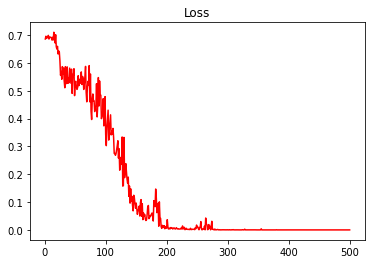

In [130]:
epforplot = np.arange(1, 501, 1)
plt.plot(epforplot, losses, 'r')

plt.title("Loss")

plt.show()

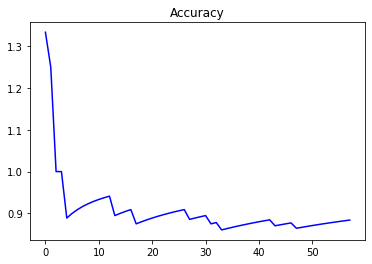

In [137]:
epforplot = np.arange(0, 58, 1)
plt.plot(epforplot, scores, 'b')

plt.title("Accuracy")

plt.show()